In [1]:
# Imports, as always...
import time

import cirq
import numpy as np
from math import log2
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import pickle

# For generating prime numbers.
from Crypto.Util import number

# Notebook progress bars.
from tqdm.notebook import tqdm

from sqif import CVP, solve_cvp

# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

# Additional imports.
from scipy.optimize import curve_fit, least_squares

# Scaling to fit to.
def scaling_function(x, alpha):
    return 1 / (2 ** (alpha * x))

# Styling for plots.
#plt.style.use('ggplot')
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

# QAOA Scaling Analysis

This is a second, cleaner analysis of the analysis in *VQAs for CVP*. This will focus on "pre-training" (or, as it is sometimes called "fixed angles") with QAOA so that the time-complexity more directly follows from the inverse of the 'success' probability.

## Attentive Pre-training

An issue with the previous analysis is that we pre-train on a single problem instance, but this leaves us a little too open to fluctuation and so makes our relationship between the scaling parameter $\alpha$ and the number of ansatz layers $p$. Therefore, we will conduct a more rigorous pre-training process using a held-out `test' set to evaluate the parameters and decide on a more generally applicable assignment. 

Nothing fancy; no need for cross-validation. We'll just give it a few training example to come up with a few assignment options, pick the best one when used on a few unseen test examples. We could then call it done there, or we could iterate this process by returning the training part with the best parameter assignment so far as the starting guess.

This pre-training scheme could allow us to play around with the idea of instance independence even more by training the parameters over instances of different sizes. Whereas previously we had trained at a fixed bit-length and used those parameters, maybe it would be a better idea to train over randomly sampled instances of bounded bit-length to allow the parameters to be truly problem independent. 

In [52]:
def find_fixed_angles(
        p : int, l : int, c : int, delta : float = .75, min_method : str = 'Nelder-Mead', epochs : int = 1, train_batch_size : int = 10, val_instances : int = 20, val_bit_length_set : np.array = np.arange(start=8, stop=129, step=8), problem_size_independence : bool = True, pretrain_bit_length : int = -1, seed : int = 42, verbose : bool = False, progress_bars : bool = False
):
    '''
    Main loop to find an assignment of angles to fix in a QAOA circuit with p ansantz layers.
    
    :param p: Number of ansatz layers (i.e. control on the depth of the QAOA circuit).
    :param l: Lattice parameter (recommended in {1, 2}).
    :param c: Precision parameter (conjectured to be positively correlated with probability to find smooth relation pairs).
    
    :param delta: Delta parameter for LLL reduction.
    :param min_method: Minimisation algorithm for finding an 'optimal' parameter assignment in each CVP.
    
    :param epochs: Number of training loops to look for parameters by researching around best guests.
    :param train_batch_size: Number of problem instances to train with in each epoch.
    :param val_instances: Number of problem instances to validate with at each bit-length in each epoch.
    :param val_bit_length_set: Range of bit-lengths to use in validation.
    :param problem_size_independence: Whether to fix pre-training bit-length or allow random problem sampling.
    :param pretrain_bit_length: The fixed bit-length problem (ignored if allowing random problem sampling).
    
    :param seed: Seed for random number generation.
    :param verbose: Whether to display epoch statistics at runtime (also whether to show epoch progress bar).
    :param progress_bars: Whether to display progress bars (except epoch progress bar, which is controlled by verbose).
    
    :return: cirq.ParamResolver object assigning 'optimal' values to the parameters of a p-deep QAOA.
    '''
    
    # Validity checks.
    assert p > 0, 'Number of ansatz layers must be a positive integer.'
    assert epochs > 0, 'Number of epochs must be a positive integer'
    assert train_batch_size > 0 and val_instances > 0, 'Batch sizes must be positive integers (yes, you must validate).'
    assert problem_size_independence or (not pretrain_bit_length and pretrain_bit_length > 0), 'If not using problem independent sampling, then pass a valid pre-train bit-length (i.e. positive integer).'
    assert problem_size_independence or 8 <= pretrain_bit_length <= 128, 'Please constrain your pre-train bit-length to [8, 128].'
    
    # Initialise.
    np.random.seed(seed)
    optimal_assignment = None
    best_alpha = np.inf
    n_bits = pretrain_bit_length
    val_stats = {}
    
    # Epoch loop.
    for epoch_idx in (tqdm(range(1, epochs + 1), desc='Epochs') if verbose else range(1, epochs + 1)):
        # Time keeping.
        tic = time.perf_counter()
        
        # Remember the parameter assignments found in this epoch.
        found_assignments = []
        
        # Training loop.
        for _ in (tqdm(range(train_batch_size), desc='Training') if progress_bars else range(train_batch_size)):
            # Determine the bit-length for the training instance.
            if problem_size_independence: n_bits = np.random.randint(low=8, high=128)
            
            # Set up a CVP.
            cvp = CVP()
            cvp.generate_cvp(N=number.getPrime(n_bits), l=l, c=c)
            
            # Set up the initial guess x0.
            if optimal_assignment is not None: x0 = np.asarray(list(optimal_assignment.param_dict.values()))
            else: x0 = None
            
            # Solve it and remember the assignments.
            _, _, _, param_assignments = solve_cvp(cvp, n_samples=1, delta=delta, p=p, x0=x0, min_method=min_method, verbose=False)
            found_assignments.append(param_assignments)
            
        # Validate each assignment to uncover whether we have a new best.
        # Validation will be given by the scaling of the probability to sample v_best, with a smaller alpha being better.
        alphas = []
        for assignment in (tqdm(found_assignments, desc='Validating') if progress_bars else found_assignments):
            # Remember the probabilities and (exact) lattice dimensions for this assignment.
            v_best_probs, lattice_dims = [], []
            for n_bits in (tqdm(val_bit_length_set, desc='Validation Bit-length') if progress_bars else val_bit_length_set):
                for _ in range(val_instances):
                    # Set up a CVP.
                    N = number.getPrime(int(n_bits))
                    cvp = CVP()
                    cvp.generate_cvp(N, l=l, c=c)
                    
                    # Solve it.
                    vs, probs, _, _ = solve_cvp(cvp, n_samples=10000, delta=delta, p=p, min_method=min_method, optimal_parameters=assignment, verbose=False)
                    
                    # Determine the probability to sample the best solution.
                    best_dist_to_target = np.inf
                    best_prob = 0
                    for v_new, prob in zip(vs, probs):
                        dist_to_target = np.linalg.norm(v_new - cvp.t)
                        
                        if dist_to_target < best_dist_to_target:
                            best_dist_to_target = dist_to_target
                            best_prob = prob
                            
                    # Add to the arrays.
                    v_best_probs.append(best_prob)
                    lattice_dims.append(l * log2(N) / log2(log2(N)))
                
            # Compute the scaling for the assignment.
            alpha = curve_fit(scaling_function, xdata=lattice_dims, ydata=v_best_probs)[0][0]
            alphas.append(alpha)
            
        # Time keeping.
        toc = time.perf_counter()
            
        # Epoch statistics.
        min_alpha = min(alphas)
        mean_alpha = np.mean(alphas)
        std_alpha = np.std(alphas)
        max_alpha = max(alphas)
        runtime = toc - tic
        epoch_stats = [min_alpha, mean_alpha, std_alpha, max_alpha, runtime]
        val_stats[epoch_idx] = epoch_stats
        
        # Write the statistics if requested.
        if verbose:
            print(f'Epoch {epoch_idx:02d} ({int(runtime):04d} s): min - {min_alpha:.3f}, mean - {mean_alpha:.3f}, std - {std_alpha:.3f}, max - {max_alpha:.3f}')
            
        # Update best if necessary.
        if min(alphas) < best_alpha:
            best_alpha = min(alphas)
            optimal_assignment = found_assignments[np.argmin(alphas)]
            
    return optimal_assignment, best_alpha, val_stats

In [53]:
optimal_assignment, best_alpha, val_stats = find_fixed_angles(p=1, l=1, c=3, train_batch_size=10, epochs=3, val_instances=20, verbose=True, progress_bars=False)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 01 (0469 s): min - 0.549, mean - 0.581, std - 0.038, max - 0.650
Epoch 02 (0461 s): min - 0.510, mean - 0.590, std - 0.051, max - 0.661
Epoch 03 (0435 s): min - 0.540, mean - 0.584, std - 0.032, max - 0.656


In [59]:
# Determining optimal assignments at each depth p.
assignments = []
for p in range(1, 11):
    print(f'For p = {p}...')
    optimal_assignment, best_alpha, _ = find_fixed_angles(p=p, l=1, c=3, train_batch_size=5, epochs=5, val_instances=10, verbose=True, progress_bars=False)
    print(f'Best parameters yielded a scaling of {best_alpha:.3f}\n')
    
    assignments.append(optimal_assignment)

For p = 1...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (0117 s): min - 0.509, mean - 0.549, std - 0.037, max - 0.606
Epoch 02 (0111 s): min - 0.534, mean - 0.598, std - 0.054, max - 0.691
Epoch 03 (0125 s): min - 0.511, mean - 0.582, std - 0.046, max - 0.646
Epoch 04 (0111 s): min - 0.524, mean - 0.576, std - 0.031, max - 0.615
Epoch 05 (0112 s): min - 0.552, mean - 0.586, std - 0.020, max - 0.609
Best parameters yielded a scaling of 0.509

For p = 2...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (0243 s): min - 0.418, mean - 0.516, std - 0.052, max - 0.570
Epoch 02 (0181 s): min - 0.341, mean - 0.398, std - 0.033, max - 0.442
Epoch 03 (0215 s): min - 0.368, mean - 0.401, std - 0.038, max - 0.471
Epoch 04 (0173 s): min - 0.374, mean - 0.443, std - 0.073, max - 0.566
Epoch 05 (0166 s): min - 0.362, mean - 0.408, std - 0.045, max - 0.485
Best parameters yielded a scaling of 0.341

For p = 3...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (0461 s): min - 0.517, mean - 0.593, std - 0.061, max - 0.690
Epoch 02 (0285 s): min - 0.356, mean - 0.412, std - 0.037, max - 0.467
Epoch 03 (0362 s): min - 0.338, mean - 0.391, std - 0.038, max - 0.453
Epoch 04 (0244 s): min - 0.390, mean - 0.461, std - 0.079, max - 0.594
Epoch 05 (0277 s): min - 0.370, mean - 0.396, std - 0.027, max - 0.444
Best parameters yielded a scaling of 0.338

For p = 4...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (1093 s): min - 0.542, mean - 0.563, std - 0.018, max - 0.592
Epoch 02 (0608 s): min - 0.511, mean - 0.554, std - 0.047, max - 0.640
Epoch 03 (0588 s): min - 0.373, mean - 0.524, std - 0.258, max - 1.039
Epoch 04 (0628 s): min - 0.346, mean - 0.409, std - 0.048, max - 0.481
Epoch 05 (0334 s): min - 0.366, mean - 0.504, std - 0.225, max - 0.953
Best parameters yielded a scaling of 0.346

For p = 5...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (0741 s): min - 0.454, mean - 0.644, std - 0.164, max - 0.902
Epoch 02 (1152 s): min - 0.317, mean - 0.374, std - 0.087, max - 0.547
Epoch 03 (0592 s): min - 0.293, mean - 0.534, std - 0.293, max - 1.066
Epoch 04 (0952 s): min - 0.265, mean - 0.307, std - 0.029, max - 0.352
Epoch 05 (0843 s): min - 0.292, mean - 0.391, std - 0.116, max - 0.574
Best parameters yielded a scaling of 0.265

For p = 6...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (2074 s): min - 0.369, mean - 0.451, std - 0.064, max - 0.562
Epoch 02 (1132 s): min - 0.379, mean - 0.408, std - 0.047, max - 0.502
Epoch 03 (1535 s): min - 0.391, mean - 0.414, std - 0.025, max - 0.453
Epoch 04 (1364 s): min - 0.359, mean - 0.378, std - 0.020, max - 0.416
Epoch 05 (1000 s): min - 0.366, mean - 0.396, std - 0.035, max - 0.460
Best parameters yielded a scaling of 0.359

For p = 7...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (3011 s): min - 0.367, mean - 0.467, std - 0.063, max - 0.545
Epoch 02 (1228 s): min - 0.396, mean - 0.587, std - 0.232, max - 0.911
Epoch 03 (1309 s): min - 0.381, mean - 0.423, std - 0.048, max - 0.513
Epoch 04 (1824 s): min - 0.358, mean - 0.479, std - 0.193, max - 0.863
Epoch 05 (1324 s): min - 0.338, mean - 0.507, std - 0.263, max - 1.032
Best parameters yielded a scaling of 0.338

For p = 8...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (3553 s): min - 0.393, mean - 0.455, std - 0.043, max - 0.515
Epoch 02 (2722 s): min - 0.282, mean - 0.342, std - 0.092, max - 0.524
Epoch 03 (1219 s): min - 0.295, mean - 0.319, std - 0.033, max - 0.385
Epoch 04 (1846 s): min - 0.301, mean - 0.342, std - 0.060, max - 0.459
Epoch 05 (1066 s): min - 0.296, mean - 0.327, std - 0.030, max - 0.384
Best parameters yielded a scaling of 0.282

For p = 9...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (2737 s): min - 0.316, mean - 0.599, std - 0.288, max - 1.119
Epoch 02 (2327 s): min - 0.283, mean - 0.394, std - 0.132, max - 0.621
Epoch 03 (3904 s): min - 0.218, mean - 0.260, std - 0.038, max - 0.326
Epoch 04 (2641 s): min - 0.217, mean - 0.313, std - 0.148, max - 0.608
Epoch 05 (2228 s): min - 0.216, mean - 0.269, std - 0.082, max - 0.432
Best parameters yielded a scaling of 0.216

For p = 10...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 (7391 s): min - 0.386, mean - 0.423, std - 0.037, max - 0.470
Epoch 02 (6723 s): min - 0.239, mean - 0.315, std - 0.114, max - 0.541
Epoch 03 (2226 s): min - 0.241, mean - 0.257, std - 0.017, max - 0.290
Epoch 04 (3637 s): min - 0.244, mean - 0.264, std - 0.024, max - 0.306
Epoch 05 (2537 s): min - 0.241, mean - 0.395, std - 0.258, max - 0.907
Best parameters yielded a scaling of 0.239


In [62]:
for p, assignment in enumerate(assignments):
    print(p+1, assignment)
    print()

1 cirq.ParamResolver({'beta_0': 0.37863725752374056, 'gamma_0': -0.007007119490716059})

2 cirq.ParamResolver({'beta_0': 0.4027136292725694, 'beta_1': 0.22164073885918953, 'gamma_0': -0.006938897376938344, 'gamma_1': -0.015730089580692504})

3 cirq.ParamResolver({'beta_0': 0.40302188069944495, 'beta_1': 0.2061230924935798, 'beta_2': 0.0021894918033828654, 'gamma_0': -0.005722690814994635, 'gamma_1': -0.014116681371384802, 'gamma_2': -0.32628410500005445})

4 cirq.ParamResolver({'beta_0': 0.6946025302634022, 'beta_1': -0.2584046487922138, 'beta_2': 0.16008561329877763, 'beta_3': -1.7706569772630223e-05, 'gamma_0': -0.005886060627310522, 'gamma_1': 0.004291241103993117, 'gamma_2': -0.021211832688352757, 'gamma_3': 120.0323653051241})

5 cirq.ParamResolver({'beta_0': -0.6213948714182078, 'beta_1': -0.15303329560224824, 'beta_2': 0.3108770241901506, 'beta_3': 0.1322233057567423, 'beta_4': -0.09198224315695477, 'gamma_0': 0.004113996558672622, 'gamma_1': 0.009652553041509266, 'gamma_2': -0.

In [73]:
# Save the optimal assignment dictionaries to files.
for p, assignment in enumerate(assignments):
    # Get the dictionary object assigning values to each parameter.
    param_dict = assignment.param_dict
    
    # Save the dictionary.
    with open(f'./results/pre-train-parameter-assignments/p={p+1}.pkl', 'wb') as file:
        pickle.dump(param_dict, file)

In [76]:
# Demonstration loading of the pickled parameter assignments.
with open(f'./results/pre-train-parameter-assignments/p={5}.pkl', 'rb') as file:
    loaded_param_dict = pickle.load(file)
    
example_assignment = cirq.ParamResolver(loaded_param_dict)
example_assignment

cirq.ParamResolver({'beta_0': -0.6213948714182078, 'beta_1': -0.15303329560224824, 'beta_2': 0.3108770241901506, 'beta_3': 0.1322233057567423, 'beta_4': -0.09198224315695477, 'gamma_0': 0.004113996558672622, 'gamma_1': 0.009652553041509266, 'gamma_2': -0.018947319167237225, 'gamma_3': -0.018273759870403077, 'gamma_4': 0.02818903544554053})

In [89]:
# Because I've been very silly and forgotten to save those runtime stats, I'll enter them all manually into a pandas DataFrame from the output to the console. I think that's punishment enough.
training_stats = pd.DataFrame({
    'p' : np.array([[p] * 5 for p in range(1, 11)]).flatten(),
    'epoch' : list(range(1, 6)) * 10,
    'min' : [
        # p = 1...
        .509, .534, .511, .524, .552,
        # p = 2...
        .418, .341, .368, .374, .362,
        # p = 3...
        .517, .356, .338, .390, .370,
        # p = 4...
        .542, .511, .373, .346, .266,
        # p = 5...
        .454, .317, .293, .265, .292,
        # p = 6...
        .369, .379, .391, .359, .366,
        # p = 7...
        .367, .379, .391, .359, .366,
        # p = 8...
        .393, .282, .295, .301, .296,
        # p = 9...
        .316, .283, .218, .217, .216,
        # p = 10...
        .386, .239, .241, .244, .241
    ],
    'mean' : [
        # p = 1...
        .549, .598, .582, .576, .586,
        # p = 2...
        .516, .398, .401, .443, .408,
        # p = 3...
        .593, .412, .391, .461, .396,
        # p = 4...
        .563, .554, .524, .409, .504,
        # p = 5...
        .644, .374, .534, .307, .391,
        # p = 6...
        .451, .408, .414, .378, .396,
        # p = 7...
        .467, .587, .423, .479, .507,
        # p = 8...
        .455, .342, .319, .342, .327,
        # p = 9...
        .599, .394, .260, .313, .269,
        # p = 10...
        .423, .315, .257, .264, .395
    ]
})

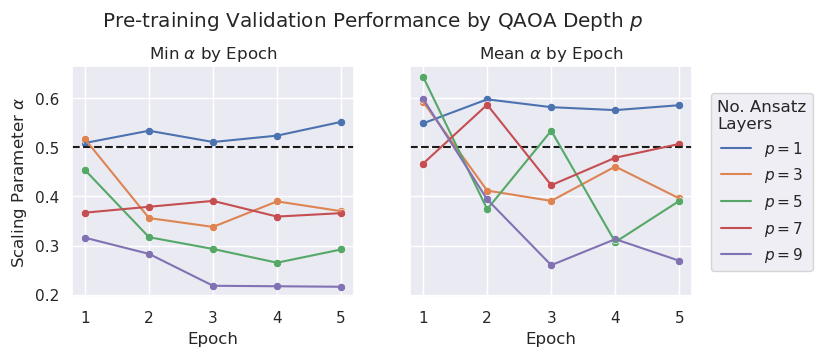

In [120]:
# Plot those stats.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey='all', figsize=(8, 3))

# Plot the scaling corresponding to a Grover speedup.
ax1.axhline(0.5, linestyle='--', color='k')
ax2.axhline(0.5, linestyle='--', color='k')

# Group by p.
grouped_by_p = training_stats.groupby('p')
group_counts = grouped_by_p.count()

# Iterate over each p.
for i, group_index in enumerate(list(group_counts.index)):
    # Only plot these ps.
    ps_to_plot = [1, 3, 5, 7, 9]
    if group_index not in ps_to_plot:
        continue
    
    group_data = grouped_by_p.get_group(group_index)
    
    # Plot the min by epoch.
    sns.scatterplot(data=group_data, x='epoch', y='min', ax=ax1)
    sns.lineplot(data=group_data, x='epoch', y='min', label=f'$p={group_index}$', ax=ax1)
    
    # Plot the mean by epoch.
    sns.scatterplot(data=group_data, x='epoch', y='mean', ax=ax2)
    sns.lineplot(data=group_data, x='epoch', y='mean', label=f'$p={group_index}$', ax=ax2)
   
ax1.set_title('Min $\\alpha$ by Epoch')
ax2.set_title('Mean $\\alpha$ by Epoch')

ax1.set_ylabel('Scaling Parameter $\\alpha$')
ax2.set_ylabel('')
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
   
fig.suptitle('Pre-training Validation Performance by QAOA Depth $p$', y=1.07)
   
ax1.get_legend().remove()
ax2.legend(title='No. Ansatz\nLayers', bbox_to_anchor=(1.04, 0.5), loc='center left')

plt.savefig('./figures/qaoa-based-pre-training/val-performance-(hued-by-p).pdf', bbox_inches='tight')

## Using Pre-trained Parameters (Data Generation)

In [2]:
def give_me_a_blank_results_dataframe():
    return pd.DataFrame(
        {
            'Bit-length' : [],
            'Lattice Dimension' : [],
            'Exact Lattice Dimension' : [],
            'N' : [],
            'l' : [],
            'c' : [],
            'p' : [],
            '|b_op - t|^2' : [],
            'P(b_op)' : [],
            '|v_best - t|^2' : [],
            'P(v_best)' : [],
            'P(|v_new - t|^2 < |b_op - t|^2)' : [],
            'P(|v_new - t|^2 > |b_op - t|^2)' : [],
            'E[|v_new - t|^2]' : [],
            'Run-time' : []
        }
    )

# The expected quality of the solution.
def expected_dist(solutions, probabilities, t):
    # Compute each solution's distance to the target.
    compute_dist = lambda x : np.linalg.norm(x - t)
    dists = np.apply_along_axis(compute_dist, 1, solutions)
    
    # Take a weighted average over these distances (weighted by their probabilities).
    return np.average(dists, weights=probabilities)

# Function to take an input semi-prime (and lattice parameter) to its exact lattice dimension.
compute_lattice_dim = lambda N, l: l * log2(N) / log2(log2(N))

In [4]:
def from_parameters_qaoa_experiment(n_bits, parameters, l, c, seed=42, n_samples=1000, delta=.75, p=1):
    np.random.seed(seed)
    N = number.getPrime(n_bits)
    
    # Time keeping.
    tic = time.perf_counter()
    
    # Set up the CVP.
    cvp = CVP()
    cvp.generate_cvp(N, l=l, c=c)
    
    # Solve it!
    solutions, probabilities, approximate_solution, _ = solve_cvp(cvp, n_samples=n_samples, delta=delta, p=p, min_method='Nelder-Mead', optimal_parameters=parameters, verbose=False)
    
    # Time keeping.
    toc = time.perf_counter()
    
    approximate_quality = np.linalg.norm(approximate_solution - cvp.t)
    
    # Determine the quality of the SQIF algorithm's solutions to the CVP (in terms of probability).
    
    # First, determine which is the best state! This computation will scale exponentially with problem size, so let's not do this in practice -- just for analysis every once in a while.
    best_dist_to_target = np.inf
    best_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < best_dist_to_target:
            best_dist_to_target = dist_to_target
            best_prob = prob
    
    # The cumulative probability to measure a state corresponding to a solution that is a least as good as b_op...
    better_cum_prob = 0
    worse_cum_prob = 0
    for v_new, prob in zip(solutions, probabilities):
        dist_to_target = np.linalg.norm(v_new - cvp.t)
        
        if dist_to_target < approximate_quality:
            better_cum_prob += prob
        elif dist_to_target > approximate_quality:
            worse_cum_prob += prob
            
    return pd.DataFrame(
        {
            'Bit-length' : [N.bit_length()],
            'Lattice Dimension' : [cvp.m],
            'Exact Lattice Dimension' : [compute_lattice_dim(N, l)],
            'N' : [N],
            'l' : [l],
            'c' : [c],
            'p' : [p],
            '|b_op - t|^2' : [approximate_quality],
            'P(b_op)' : [1 - (better_cum_prob + worse_cum_prob)],
            '|v_best - t|^2' : [best_dist_to_target],
            'P(v_best)' : [best_prob],
            'P(|v_new - t|^2 < |b_op - t|^2)' : [better_cum_prob],
            'P(|v_new - t|^2 > |b_op - t|^2)' : [worse_cum_prob],
            'E[|v_new - t|^2]' : [expected_dist(solutions, probabilities, cvp.t)],
            'Run-time' : [toc - tic]
        }
    )

# Grab out pre-trained parameter assignments for the given p.
p = 10
with open(f'./results/pre-train-parameter-assignments/p={p}.pkl', 'rb') as file:
    loaded_param_dict = pickle.load(file) 
    example_assignment = cirq.ParamResolver(loaded_param_dict)

from_parameters_qaoa_experiment(128, example_assignment, l=1, c=3, n_samples=100000, p=p)

,Bit-length,Lattice Dimension,Exact Lattice Dimension,N,l,c,p,|b_op - t|^2,P(b_op),|v_best - t|^2,P(v_best),P(|v_new - t|^2 < |b_op - t|^2),P(|v_new - t|^2 > |b_op - t|^2),E[|v_new - t|^2],Run-time
0,128,18,18.200417,202088713771981851221143402946035540657,1,3,10,37.616486,0.04986,37.603191,0.02836,0.02836,0.92178,38.194898,2.379783


In [6]:
# Decide on the number of samples to take at a given bit-length. We need enough for an accurate probability.
def n_samples_to_take(n_bits):
    if n_bits < 16:
        return 1000
    elif n_bits < 64:
        return 10000
    else:
        return 100000

# Consider the depths for which we have pre-trained parameter assignments.
for p in tqdm(range(2, 11), desc='Ansatz Depths'):
    # Get an empty results dataframe.
    results = give_me_a_blank_results_dataframe()
    
    # Load in the attentively pre-trained parameter values for this depth.
    with open(f'./results/pre-train-parameter-assignments/p={p}.pkl', 'rb') as file:
        loaded_param_dict = pickle.load(file) 
        pretrained_param_resolver = cirq.ParamResolver(loaded_param_dict)
    
    # Consider a bunch of bit-lengths.
    for n_bits in tqdm(range(4, 128), desc='Bit-lengths'):
        # Repeat them a fair few times to try out a few prime lattice permutations randomly.
        for _ in range(30):
            # Perform the experiment and save the outcome.
            experiment_outcome = from_parameters_qaoa_experiment(n_bits, pretrained_param_resolver, l=1, c=3, seed=42, n_samples=n_samples_to_take(n_bits), delta=.75, p=p)
            results = pd.concat([results, experiment_outcome])
            
    # Write to file. I'm doing this at the end of a run, rather than at runtime, because... reasons.
    results.to_csv(f'./results/quantum-accelerated-cvp/qaoa-based-(p={p})-attentive-pretraining-huge.csv')

Ansatz Depths:   0%|          | 0/9 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

Bit-lengths:   0%|          | 0/124 [00:00<?, ?it/s]

## Using Pre-trained Parameters (Analysis)

## Considering Worst-cases

Because the average scaling may not be so interesting, we consider how well the best 10% of QAOA runs scale so as to get an idea for the worst-case requirements to make the CVP secure against this kind of attack (e.g. if an attacker gets lucky, what kind of scaling might they get?).